# Model Selecton and Experimentation

In this notebook, I try different models to predict the property prices based on my curated dataset.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [11]:
final_features = pd.read_pickle(r"C:\Users\Roydon\Desktop\Property Price Project\Final Project Code\Data\final_features.pkl")
final_features

,num_area,lease_left,float_x,float_y,num_price,floor_range,year_transacted,property_type
0,524.3,999.0,22734.925781,29502.419922,5500000,0.0,3.0,7.0
1,308.0,999.0,22734.925781,29502.419922,5000000,0.0,1.0,7.0
2,314.0,999.0,22734.925781,29502.419922,4750000,0.0,1.0,7.0
3,308.0,999.0,22734.925781,29502.419922,5200000,0.0,4.0,7.0
4,257.0,999.0,20914.199219,30589.107422,4600000,0.0,5.0,6.0
...,...,...,...,...,...,...,...,...
131733,304.1,999.0,27055.871094,45402.906250,3430000,0.0,5.0,6.0
131734,268.2,999.0,27055.871094,45402.906250,2480000,0.0,0.0,6.0
131735,215.0,999.0,27055.871094,45402.906250,1100000,0.0,2.0,1.0
131736,295.3,999.0,27055.871094,45402.906250,3400000,0.0,4.0,6.0


In [12]:
from sklearn.model_selection import train_test_split

# Split data into training and validation data, for both features and target
y = final_features["num_price"]
X = final_features[["num_area", "floor_range", "year_transacted", "property_type", "lease_left", "float_x", "float_y"]]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=0)

### Random Forest Regressor Implementation (Vs dummy)

Here I implement a dummy regressor that outputs the mean for all predictions, as a benchmark model to compare my subsequent models with. I will compare the Mean Absolute Error (MAE), Mean Squared Error (MSE) and Root Mean Squared Error (RMSE). First, I compare it with Random Forest Regressor.

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Dummy Model (mean)
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(train_X, train_y)
data_pred = dummy_regr.predict(val_X)

print("Mean Absolute Error (Dummy): {}".format(mean_absolute_error(val_y, data_pred)))
print("Mean Squared Error (Dummy): {}".format(mean_squared_error(val_y, data_pred)))
print("Root Mean Squared Error (Dummy): {}".format((mean_squared_error(val_y, data_pred)**0.5)))
print("\n")

# Random Forest Regressor
rand_forest = RandomForestRegressor()
rand_forest.fit(train_X, train_y)
data_pred = rand_forest.predict(val_X)

# Printing Accuracy of Model
print("Mean Absolute Error (Rand_forest): {}".format(mean_absolute_error(val_y, data_pred)))
print("Mean Squared Error (Rand_forest): {}".format(mean_squared_error(val_y, data_pred)))
print("Root Mean Squared Error (Rand_forest): {}".format((mean_squared_error(val_y, data_pred)**0.5)))

Mean Absolute Error (Dummy): 1024629.4251960467
Mean Squared Error (Dummy): 5285973826681.23
Root Mean Squared Error (Dummy): 2299124.5783300283


Mean Absolute Error (Rand_forest): 124900.6739546748
Mean Squared Error (Rand_forest): 528998839974.4611
Root Mean Squared Error (Rand_forest): 727323.0643768016


The **random forest regressor** performed **worse than the dummy regressor for the MAE**, but performed **much better for MSE and RMSE**, which penalises more for wrong predictions. The random forest is more robust in handling outlier cases, which exist in the dataset, especially for the freehold and landed properties, as I observed in the EDA notebook.

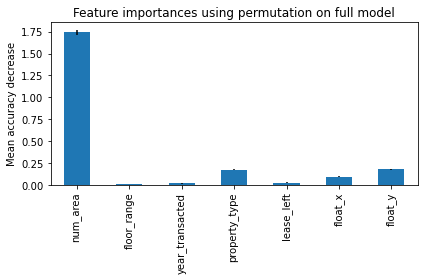

In [25]:
from sklearn.inspection import permutation_importance

# Calculating Feature Importance
result = permutation_importance(rand_forest, val_X, val_y)
feature_names = ["num_area", "floor_range", "year_transacted", "property_type", "lease_left", "float_x", "float_y"]
forest_importances = pd.Series(result.importances_mean, index=feature_names)

# Plotting Graph
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

As seen from the above plot, the random forest model uses floor area of the property as the most significant deciding factor of price for this model, and the other features do not appear significant in the prediction process.

The current data and features available may not be generalizing well for freehold and landed properties. I believe with the current dataset, I may be able to give more accurate predictions with non-landed properties, with lease period within 100 years. For these properties, the other features may have a greater significance and model may be less skewed by outlier cases.

I hence decided to try experimenting the process on a subset of the dataset to see if prediction performance improves. The subset I chose this time only contained "condominiums", "apartments" and "executive condominium" property types, with lease period less than 100 yrs.

## Testing with subset of dataset

In [10]:
# Prepare subset of dataset (non-landed, lease within 100 yrs)
datasetWithoutLanded_df = final_features.copy()
outlier_index = datasetWithoutLanded_df[(datasetWithoutLanded_df.lease_left > 101) | 
                                        (datasetWithoutLanded_df.property_type > 3)].index
datasetWithoutLanded_df.drop(outlier_index, axis=0, inplace=True)
datasetWithoutLanded_df = datasetWithoutLanded_df.reset_index()

# New train-test split
y2 = datasetWithoutLanded_df["num_price"]
X2 = datasetWithoutLanded_df[["num_area", "floor_range", "year_transacted", "property_type", "lease_left", "float_x", "float_y"]]
train_X, val_X, train_y, val_y = train_test_split(X2, y2,random_state = 0)

# Dummy Model (mean)
dummy_regr2 = DummyRegressor(strategy="mean")
dummy_regr2.fit(train_X, train_y)
data_pred = dummy_regr2.predict(val_X)

print("Mean Absolute Error (Dummy): {}".format(mean_absolute_error(val_y, data_pred)))
print("Mean Squared Error (Dummy): {}".format(mean_squared_error(val_y, data_pred)))
print("Root Mean Squared Error (Dummy): {}".format((mean_squared_error(val_y, data_pred)**0.5)))
print("\n")

# Random Forest Regressor
rand_forest_2 = RandomForestRegressor()
rand_forest_2.fit(train_X, train_y)
data_pred = rand_forest_2.predict(val_X)

print("Mean Absolute Error (Rand_forest): {}".format(mean_absolute_error(val_y, data_pred)))
print("Mean Squared Error (Rand_forest): {}".format(mean_squared_error(val_y, data_pred)))
print("Root Mean Squared Error (Rand_forest): {}".format((mean_squared_error(val_y, data_pred)**0.5)))

Mean Absolute Error (Dummy): 464581.81872845744
Mean Squared Error (Dummy): 603299436073.0874
Root Mean Squared Error (Dummy): 776723.5261488397


Mean Absolute Error (Rand_forest): 50252.91841137859
Mean Squared Error (Rand_forest): 18587304674.689297
Root Mean Squared Error (Rand_forest): 136335.26570439982


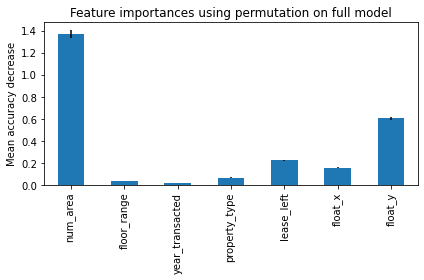

In [28]:
# Calculating Feature Importance
result = permutation_importance(rand_forest_2, val_X, val_y)
feature_names = ["num_area", "floor_range", "year_transacted", "property_type", "lease_left", "float_x", "float_y"]
forest_importances = pd.Series(result.importances_mean, index=feature_names)

# Plotting Graph
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Significant improvement in the both models can be seen for both the dummy and the random forest model.

The coordinates ('float_x' and 'float_y') and 'lease_left' features were used more in the prediction process, while property type reduced importance as a feature. In this case the random forest model could utilize other features provided more, and beat the dummy model signifacntly.

I proceeded to build a model with only landed property data, to observe if a similar improvement happens.

In [14]:
datasetWithoutStrata_df = final_features.copy()
outlier_index = datasetWithoutStrata_df[(datasetWithoutStrata_df.property_type < 4)].index
datasetWithoutStrata_df.drop(outlier_index, axis=0, inplace=True)
datasetWithoutStrata_df = datasetWithoutStrata_df.reset_index()

# Training the model
y3 = datasetWithoutStrata_df["num_price"]
X3 = datasetWithoutStrata_df[["num_area", "floor_range", "year_transacted", "property_type", "lease_left", "float_x", "float_y"]]
train_X, val_X, train_y, val_y = train_test_split(X3, y3,random_state = 0)

# Dummy Model (mean)
dummy_regr3 = DummyRegressor(strategy="mean")
dummy_regr3.fit(train_X, train_y)
data_pred = dummy_regr3.predict(val_X)

print("Mean Absolute Error (Dummy): {}".format(mean_absolute_error(val_y, data_pred)))
print("Mean Squared Error (Dummy): {}".format(mean_squared_error(val_y, data_pred)))
print("Root Mean Squared Error (Dummy): {}".format((mean_squared_error(val_y, data_pred)**0.5)))
print("\n")

# Random Forest Regressor
rand_forest_3 = RandomForestRegressor()
rand_forest_3.fit(train_X, train_y)
data_pred = rand_forest_3.predict(val_X)

print("Mean Absolute Error (Rand_forest): {}".format(mean_absolute_error(val_y, data_pred)))
print("Mean Squared Error (Rand_forest): {}".format(mean_squared_error(val_y, data_pred)))
print("Root Mean Squared Error (Rand_forest): {}".format((mean_squared_error(val_y, data_pred)**0.5)))

Mean Absolute Error (Dummy): 2368177.1534657977
Mean Squared Error (Dummy): 19715085162011.46
Root Mean Squared Error (Dummy): 4440167.2448243955


Mean Absolute Error (Rand_forest): 516887.46985575213
Mean Squared Error (Rand_forest): 2605308817264.3364
Root Mean Squared Error (Rand_forest): 1614096.904545801


As seen above, while the model trained with the given features did significantly better than the dummy, it was not robust enough to accurately predict prices for landed properties, performing even more poorly than the model trained with the whole dataset. This may be because freehold property prices are affected more greatly by other factors (age of property, current state of the property etc.) which were not accounted for.

## Model Selection (Performance of other types of regressor models)

From here onwards, I decided to pivot my project to only predict prices for non-landed properties within the 100 year lease period.

In the final cell below, I tested a few other types of models to compare against the tree based model, Random Forest. 
- Ridge Regression:  to test parametric models.
- Multi-layer Perceptron Regressor: to test deep learning models. (Tweaked the learning rate and max-iteration for this, since default learning rate could not converge with the default number of iterations)

In [21]:
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor

# Reset train-test split to subset of dataset
train_X, val_X, train_y, val_y = train_test_split(X2, y2,random_state = 0)

# Multi-variable Linear Regression
linear_reg = linear_model.Ridge(alpha=.5)
linear_reg.fit(train_X, train_y)
data_pred = linear_reg.predict(val_X)

print("Mean Absolute Error (Ridge_reg): {}".format(mean_absolute_error(val_y, data_pred)))
print("Mean Squared Error (Ridge_reg): {}".format(mean_squared_error(val_y, data_pred)))
print("Root Mean Squared Error (Ridge_reg): {}".format((mean_squared_error(val_y, data_pred)**0.5)))
print("\n")

# Neural Network (Multi-layer Perceptron Regressor) (Default Params)
neural_network_reg = MLPRegressor(random_state=1, solver='adam', max_iter=500, learning_rate_init= 0.01)
neural_network_reg.fit(train_X, train_y)
data_pred = neural_network_reg.predict(val_X)

print("Mean Absolute Error (Neural_network_reg): {}".format(mean_absolute_error(val_y, data_pred)))
print("Mean Squared Error (Neural_network_reg): {}".format(mean_squared_error(val_y, data_pred)))
print("Root Mean Squared Error (Neural_network_reg): {}".format((mean_squared_error(val_y, data_pred)**0.5)))

Mean Absolute Error (Ridge_reg): 241932.6675954855
Mean Squared Error (Ridge_reg): 202936730694.41586
Root Mean Squared Error (Ridge_reg): 450484.99497143726


Mean Absolute Error (Neural_network_reg): 216208.7200071003
Mean Squared Error (Neural_network_reg): 169923617576.2644
Root Mean Squared Error (Neural_network_reg): 412217.9248604607


Compared to random forest regressor:

- Mean Absolute Error (Rand_forest): 50252.91841137859
- Mean Squared Error (Rand_forest): 18587304674.689297
- Root Mean Squared Error (Rand_forest): 136335.26570439982

Without any hyperparameter tuning, tree based methods seem to outperform other types of models significantly.

**Conclusion:**
- With this limited amount of features in the dataset acquired, the model was not robust enough to predict accurately the prices of landed properties. Reducing the scope to only condominiums, executive condominiums and apartments within 100 years leasehold significantly improved accuracy.

- Comparing different types of models, it appears that Random Forest performed the best for this prediction task.

**Constraints and Possible Future Areas of Improvement:**
- There are many more factors that could affect property prices, but were not included in the features. One possible way I could go about solving this would be to obtain data from other sources such as the OneMap API, and extract new features such as the amenities and scenery near the property.

- Another possible approach could be to use different types of models (that perform better on less representative datasets) to predict prices of landed properties, and use the different models to output predictions for different categories depending on user input (landed or non-landed etc.), should I want this project to still predict prices for all types of private property.